<a href="https://colab.research.google.com/github/jchburmester/tree-decisions/blob/main/TD_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree Decisions - Data Notebook

This notebook is hosting a (prototype) modeling framework for tree growth and carbon deposition in wood, with a focus on tree-ring increments and small-scale processes.
- An updated version of this notebook will be stored in the Github Repository: https://github.com/jchburmester/tree-decisions
The datasets are stored in a Google Drive and will be directly accessed from this notebook

#### Imports

In [1]:
import requests
import json
import time
import os
import re
from bs4 import BeautifulSoup

# Mapping.
import folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# To access Drive.
from google.colab import userdata
from google.colab import drive

# For direct access to Zenodo.
zenodo_token = userdata.get('ZENODO_TOKEN')

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Data Crawling


##### Scraping ITRDB for Tree Ring Data for Sweden

In [ ]:
url = "https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/europe/"
response = requests.get(url)
response.raise_for_status()

soup = BeautifulSoup(response.text, 'html.parser')

# Destination directory in Google Drive
download_dir = '/content/gdrive/My Drive/tree-decisions/data/tree-ring/data_w_meta'
os.makedirs(download_dir, exist_ok=True)

filtered_files = []

for link in soup.find_all('a'):
    href = link.get('href')
    if href:
        href_lower = href.lower()
        if 'swe' in href_lower and href_lower.endswith('.txt'):
            filtered_files.append(href)

print(f"Found {len(filtered_files)} files to download")

for filename in filtered_files:
    file_url = url + filename
    local_path = os.path.join(download_dir, filename)
    print(f"Downloading {filename} to Google Drive...")
    try:
        r = requests.get(file_url)
        r.raise_for_status()
        with open(local_path, 'wb') as f:
            f.write(r.content)
    except Exception as e:
        print(f"Failed to download {filename}: {e}")

print("All downloads complete.")

Found 146 files to download
All downloads complete.


#### Data Loading


**Suffix table**
- no suffix -> total ring width (mm)
- "e" -> earlywood width (mm)
- "l" -> latewood width (mm)
- "n" -> minimum density (gram per decimeter)
- "x" -> maximum density (gram per decimeter)
- "p" -> latewood percentage

Without meta_data: 010p, 011p, 012p, 013p, 014p, 015p, 016p, 017p -> can ignore for the time being

**Number of Datasets**
- total ring width (59+x)

##### ITRDB
https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/europe/

In [ ]:
# Loading from Drive.
itrdb_path = '/content/gdrive/My Drive/tree-decisions/data/tree-ring/itrdb'

In [6]:
# Read those with metadata.
def read_rwl_with_metadata(file_path):
    metadata = {
        'Site_Name': None,
        'Northernmost_Latitude': None,
        'Southernmost_Latitude': None,
        'Easternmost_Longitude': None,
        'Westernmost_Longitude': None,
        'Elevation': None,
        'Parameter_Keywords': None,
        'Common_Name': None,
        'Tree_Species_Code': None
    }
    with open(file_path, 'r') as f:
        lines = f.readlines()

    header_lines = [line.strip() for line in lines if line.startswith('#')]

    # Define regex patterns to capture values
    patterns = {
        'Site_Name': re.compile(r'Site[_ ]*Name([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
        'Northernmost_Latitude': re.compile(r'Northernmost[_ ]*Latitude([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
        'Southernmost_Latitude': re.compile(r'Southernmost[_ ]*Latitude([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
        'Easternmost_Longitude': re.compile(r'Easternmost[_ ]*Longitude([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
        'Westernmost_Longitude': re.compile(r'Westernmost[_ ]*Longitude([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
        'Elevation': re.compile(r'Elevation([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
        'Parameter_Keywords': re.compile(r'Parameter[_ ]*Keywords([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
        'Common_Name': re.compile(r'Common[_ ]*Name([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
        'Tree_Species_Code': re.compile(r'Tree[_ ]*Species[_ ]*Code([_\w]*)?\s*[:=]\s*(.*)', re.IGNORECASE),
    }

    for line in header_lines:
        for key, pattern in patterns.items():
            match = pattern.search(line)
            if match:
                metadata[key] = match.group(2).strip()

    df = pd.read_csv(
        file_path,
        sep=r'\s+',
        engine='python',
        comment='#',
        header=None,
        on_bad_lines='skip'
    )

    return df, metadata

In [10]:
# For datasets with total ring width (no suffix in name).
total_width_meta = {}
total_width_pattern = re.compile(r"\d+-rwl-noaa")
w_total_width_pattern = re.compile(r"\d{3}w-rwl-noaa")

# For datasets with suffix in name, so other variables.
other_var_meta = {}
other_var_pattern = re.compile(r"\d+[a-zA-Z]+-rwl-noaa")

for filename in os.listdir(itrdb_path):
    if w_total_width_pattern.search(filename):
        fpath = os.path.join(itrdb_path, filename)
        try:
            df, meta = read_rwl_with_metadata(fpath)
            total_width_meta[filename] = {'data': df, 'meta': meta}
        except Exception as e:
            print(f"Failed {filename} due to {e}")
    elif total_width_pattern.search(filename):
        fpath = os.path.join(itrdb_path, filename)
        try:
            df, meta = read_rwl_with_metadata(fpath)
            total_width_meta[filename] = {'data': df, 'meta': meta}
        except Exception as e:
            print(f"Failed {filename} due to {e}")
    elif other_var_pattern.search(filename):
        fpath = os.path.join(itrdb_path, filename)
        try:
            df, meta = read_rwl_with_metadata(fpath)
            other_var_meta[filename] = {'data': df, 'meta': meta}
        except Exception as e:
            print(f"Failed {filename} due to {e}")

##### Gentree
https://springernature.figshare.com/collections/The_GenTree_Dendroecological_Collection_tree-ring_and_wood_density_data_from_seven_tree_species_across_Europe/4561037

In [32]:
# Paths.
gt_data_path = '/content/gdrive/My Drive/tree-decisions/data/tree-ring/gentree/trw_long_format.csv'
gt_meta_path = '/content/gdrive/My Drive/tree-decisions/data/tree-ring/gentree/metadata.txt'
gt_sets_path = '/content/gdrive/My Drive/tree-decisions/data/tree-ring/gentree/per_cite'
gt_sites_path = '/content/gdrive/My Drive/tree-decisions/data/tree-ring/gentree/gentree_sites.csv'
gt_trees_path = '/content/gdrive/My Drive/tree-decisions/data/tree-ring/gentree/gentree_trees.csv'

In [26]:
# Load data.
gt_data = pd.read_csv(
    gt_data_path,
    engine='python',
    on_bad_lines='skip'
)

In [28]:
# Load site information.
gt_sites = pd.read_csv(
    gt_sites_path,
    engine='python',
    on_bad_lines='skip',
    encoding='latin1'
)

In [33]:
# Load data for 9 sites in Sweden.


##### National Inventories - Sweden

In [22]:
swe_inv_path = '/content/gdrive/My Drive/tree-decisions/data/tree-ring/nat_inv_swe'

#### Pre-Processing

In [ ]:
def preprocess(filename, df, meta):
    new_columns = df.iloc[0]
    df_clean = df[1:].copy()
    df_clean.columns = new_columns
    df_clean.reset_index(drop=True, inplace=True)

    df_clean = df_clean.apply(pd.to_numeric, errors='coerce').astype(float)

    if 'age_CE' in df_clean.columns:
        df_clean.rename(columns={'age_CE': 'year'}, inplace=True)

    df_clean.columns = df_clean.columns.str.replace('_raw', '')

    if 'year' in df_clean.columns:
        #df_clean['year'] = pd.to_numeric(df_clean['year'], errors='coerce')
        #df_clean = df_clean[df_clean['year'].notna() & (df_clean['year'] >= 1900)].copy()
        #df_clean.reset_index(drop=True, inplace=True)
        df_clean['year'] = df_clean['year'].astype(int)

    if 'Elevation' in meta and meta['Elevation'] is not None:
        try:
            elevation_val = float(meta['Elevation'])
            if elevation_val < 0:
                meta['Elevation'] = np.nan
        except Exception:
            # Ignore if not convertible
            pass
    """
    for marker_val in [999, -9999]:
        # Check if marker exists anywhere
        if df_clean.isin([marker_val]).any().any():
            print(filename)
            # Locate cells containing marker_val
            loc = df_clean.isin([marker_val])
            # For each cell with marker, capture the year and marker value
            for row_idx, row in loc.iterrows():
                for col_name, val in row.items():
                    if val:  # True means marker found here
                        year_val = df_clean.at[row_idx, 'year']
                        meta['markers'] = {'year': year_val, 'value': marker_val, 'column': col_name}
                        #print(meta)
                        df_clean.at[row_idx, col_name] = np.nan
    """
    return df_clean, meta

def unit_change(df, meta):
    markers = meta.get('markers', None)

    if isinstance(markers, dict):
        marker_val = markers.get('value', None)
    elif isinstance(markers, list) and len(markers) > 0:
        marker_val = markers[-1].get('value', None)
    else:
        marker_val = None

    if marker_val == 999:
        scale_factor = 0.01
    elif marker_val == -9999:
        scale_factor = 0.001
    else:
        # Check the distribution of values to infer appropriate scale
        cols_to_scale = [col for col in df.columns if col != 'year' and pd.api.types.is_numeric_dtype(df[col])]
        values = df[cols_to_scale].to_numpy().flatten()
        values = values[~np.isnan(values)]
        # Use median as robust indicator of central value
        median_value = np.median(values) if len(values) > 0 else 0
        # Heuristic: if median is >= 10, assume data is in double/triple digits -> scale by 0.01
        scale_factor = 0.01 if median_value >= 10 else 1

    cols_to_scale = [col for col in df.columns if col != 'year' and pd.api.types.is_numeric_dtype(df[col])]
    # Ensure columns are float before multiplication to suppress warnings
    df.loc[:, cols_to_scale] = df.loc[:, cols_to_scale].astype(float).multiply(scale_factor)
    return df

In [ ]:
total_width_meta.keys()

dict_keys(['swe347-rwl-noaa.txt', 'swe348-rwl-noaa.txt', 'swe349-rwl-noaa.txt', 'swe350-rwl-noaa.txt', 'swe351-rwl-noaa.txt', 'swe352-rwl-noaa.txt', 'swe353-rwl-noaa.txt', 'swe354-rwl-noaa.txt', 'swe355-rwl-noaa.txt', 'swe356-rwl-noaa.txt', 'swe357-rwl-noaa.txt', 'swe358-rwl-noaa.txt', 'swe359-rwl-noaa.txt', 'swe360-rwl-noaa.txt', 'swe361-rwl-noaa.txt', 'swe362-rwl-noaa.txt', 'swed002-rwl-noaa.txt', 'swed004-rwl-noaa.txt', 'swed006-rwl-noaa.txt', 'swed007-rwl-noaa.txt', 'swed008-rwl-noaa.txt', 'swed009-rwl-noaa.txt', 'swed010-rwl-noaa.txt', 'swed011-rwl-noaa.txt', 'swed012-rwl-noaa.txt', 'swed013-rwl-noaa.txt', 'swed014-rwl-noaa.txt', 'swed015-rwl-noaa.txt', 'swed016-rwl-noaa.txt', 'swed017-rwl-noaa.txt', 'swed018-rwl-noaa.txt', 'swed019w-rwl-noaa.txt', 'swed020w-rwl-noaa.txt', 'swed021w-rwl-noaa.txt', 'swed022w-rwl-noaa.txt', 'swed023w-rwl-noaa.txt', 'swed302-rwl-noaa.txt', 'swed303-rwl-noaa.txt', 'swed304-rwl-noaa.txt', 'swed305-rwl-noaa.txt', 'swed306-rwl-noaa.txt', 'swed307-rwl-noa

In [ ]:
for c, filename in enumerate(total_width_meta):
    #print(c)
    raw_df = total_width_meta[filename]['data']
    meta = total_width_meta[filename]['meta']

    cleaned_df, updated_meta = preprocess(filename, raw_df, meta)
    #scaled_df = unit_change(cleaned_df, updated_meta)

    total_width_meta[filename]['cleaned_data'] = cleaned_df
    total_width_meta[filename]['meta'] = updated_meta

In [ ]:
total_width_meta['swed019w-rwl-noaa.txt']['meta']

{'Site_Name': 'Torneträsk r+f., Bartoli',
 'Northernmost_Latitude': '68.23',
 'Southernmost_Latitude': '68.23',
 'Easternmost_Longitude': '19.67',
 'Westernmost_Longitude': '19.67',
 'Elevation': '400',
 'Parameter_Keywords': 'ring width',
 'Common_Name': 'Scots pine',
 'Tree_Species_Code': 'PISY'}

#### Data Visualisation & Analysis
Data visualisation will help to show general patterns and anomalies within the dataset. We will then conduct regression and correlation analyses to examine relationships. Finally, statistical and ML approaches will be used to identify more complex and less obvious trends, to improve our understanding of carbon storage processes in wood biomass.

In [ ]:
def plot_metadata_locations(dataframes_meta):
    # Create a base map (center is arbitrary, adjust as needed)
    m = folium.Map(location=[0, 0], zoom_start=2)

    for filename, content in dataframes_meta.items():
        meta = content['meta']
        try:
            lat_north = float(meta.get('Northernmost_Latitude', None))
            lat_south = float(meta.get('Southernmost_Latitude', None))
            lon_east = float(meta.get('Easternmost_Longitude', None))
            lon_west = float(meta.get('Westernmost_Longitude', None))

            # Add marker at approximate center
            center_lat = (lat_north + lat_south) / 2
            center_lon = (lon_east + lon_west) / 2

            popup_text = f"{filename}<br>" + \
                         f"North: {lat_north}, South: {lat_south}<br>" + \
                         f"East: {lon_east}, West: {lon_west}"

            folium.Marker(
                location=[center_lat, center_lon],
                popup=popup_text,
                icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(m)

            # Optional: add bounding box rectangle
            bounds = [[lat_south, lon_west], [lat_north, lon_east]]
            folium.Rectangle(bounds=bounds, color='green', fill=True, fill_opacity=0.1).add_to(m)

        except (TypeError, ValueError):
            # Skip if any coordinate is missing or invalid
            continue

    return m

map_object = plot_metadata_locations(total_width_meta)
map_object.save('/content/gdrive/My Drive/tree-decisions/data/tree-ring/sweden_tr_locations.html')

In [ ]:
# Check for outliers.
all_values = []
for filename, content in total_width_meta.items():
    df = content.get('cleaned_data', None)
    if df is not None:
        # Select all columns except 'year'
        df_no_year = df.loc[:, df.columns != 'year']
        # Flatten and filter out NaNs
        values = df_no_year.to_numpy().flatten()
        values = values[~np.isnan(values)]
        all_values.extend(values)

all_values = np.array(all_values)

In [ ]:
for filename, content in total_width_meta.items():
    df = content.get('cleaned_data', None)
    if df is not None and 'year' in df.columns:
        # Select all columns except 'year'
        df_no_year = df.loc[:, df.columns != 'year']
        # Mask for values > 5
        mask = df_no_year > 5

        if mask.any().any():
            print(f"Filename: {filename}")
            # Iterate over True positions in mask to print year and value
            for row_idx, col_name in zip(*np.where(mask.to_numpy())):
                year_val = df.at[row_idx, 'year']
                value = df_no_year.iat[row_idx, col_name]
                column_name = df_no_year.columns[col_name]
                print(f" Year: {year_val}, Column: {column_name}, Value: {value}")

Filename: swe348-rwl-noaa.txt
 Year: 1997, Column: ESA1034a, Value: 5.9
 Year: 2002, Column: ESA1034a, Value: 7.85
 Year: 2006, Column: ESA1034a, Value: 5.66
 Year: 2011, Column: ESA1014b, Value: 5.89
Filename: swe349-rwl-noaa.txt
 Year: 1936, Column: ESA2127a, Value: 5.44
 Year: 1937, Column: ESA2127a, Value: 8.3
 Year: 1938, Column: ESA2127a, Value: 5.42
 Year: 1939, Column: ESA2127a, Value: 5.45
 Year: 1952, Column: ESA2112b, Value: 5.07
 Year: 1953, Column: ESA2112b, Value: 8.41
 Year: 1953, Column: ESA2117a, Value: 5.05
 Year: 1954, Column: ESA2112b, Value: 7.33
 Year: 1955, Column: ESA2112b, Value: 7.1
 Year: 1956, Column: ESA2112b, Value: 7.01
 Year: 1957, Column: ESA2112b, Value: 7.98
 Year: 1958, Column: ESA2112b, Value: 7.81
 Year: 1959, Column: ESA2112b, Value: 6.24
 Year: 1959, Column: ESA2117a, Value: 5.42
 Year: 1960, Column: ESA2112b, Value: 6.36
 Year: 1960, Column: ESA2117a, Value: 5.16
 Year: 1963, Column: ESA2112a, Value: 8.14
 Year: 1963, Column: ESA2112b, Value: 5.

Global min: 0.0
Global max: 10.21


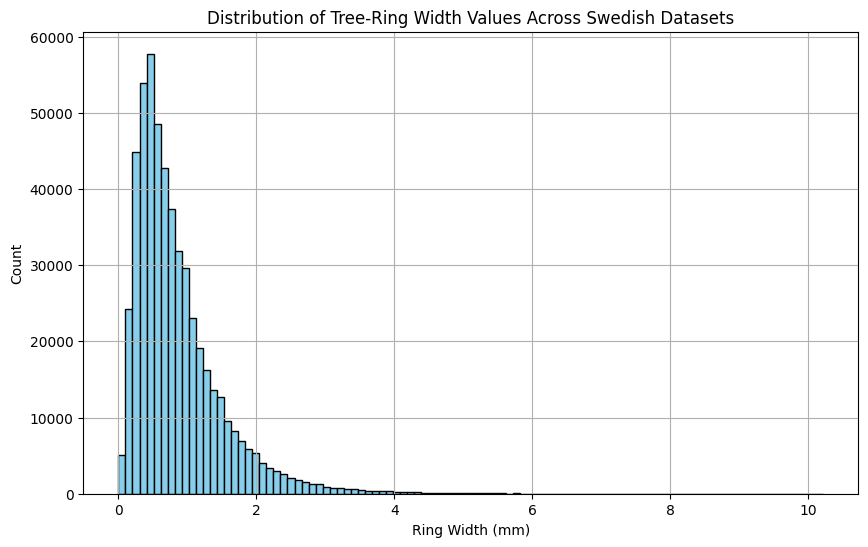

In [ ]:
print(f"Global min: {all_values.min()}")
print(f"Global max: {all_values.max()}")

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(all_values, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Tree-Ring Width Values Across Swedish Datasets')
plt.xlabel('Ring Width (mm)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
print("Values above 100:")
print(all_values[all_values > 100])

Values above 100:
[1900. 1901. 1902. ... 2007. 2008. 2009.]


#### Sub-Model Prototype
Based on insights from the data analysis, process equations will be implemented to represent the system's carbon dynamics. The model will undergo calibration, validation, and uncertainty analysis to ensure robustness. Finally, the calibrated sub-model will be integrated into the existing head-model framework for a more complete ecosystem simulation.

In [ ]:
# Here will be code.